<a href="https://colab.research.google.com/github/gecco-evojax/evojax/blob/main/notebooks/CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jan  6 11:28:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |      0MiB / 16160MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# @title Install Packages

from IPython.display import clear_output

!pip install git+https://github.com/gecco-evojax/evojax.git@main

clear_output()

In [4]:
# @title Import Libraries

import time
import numpy as np
from IPython.display import Image

import jax
from jax import random

from evojax import SimManager
from evojax.algo import PGPE
from evojax.policy import MLPPolicy
from evojax.task.cartpole import CartPoleSwingUp

In [5]:
# @title Confirm JAX Backend

print('jax backend: {}'.format(jax.devices()))
print('You need to restart the runtime if the output above is not GPU')

jax backend: [GpuDevice(id=0, process_index=0)]
You need to restart the runtime if the output above is not GPU


# Learn to Solve the CartPoleSwingUp Task

In [6]:
# @title Set hyper-parameters

pop_size = 64  # @param
num_evals = 100  # @param
num_repeats = 16  # @param
max_train_iters = 1000  # @param
seed =   2022# @param

In [7]:
# @title Training

policy = MLPPolicy(
    input_dim=5,
    hidden_dims=[64, 64],
    output_dim=1,
)
print('#params={}'.format(policy.num_params))

for hard_ver in [False, True]:
    
    reward_threshold = 600 if hard_ver else 900
    
    train_env = CartPoleSwingUp(
        harder=hard_ver,
        test=False,
    )
    valid_env = CartPoleSwingUp(
        harder=hard_ver,
        test=True,
    )    
    sim_mgr = SimManager(
        n_repeats=num_repeats,
        test_n_repeats=1,
        pop_size=pop_size,
        n_evaluations=num_evals,
        policy_net=policy,
        train_vec_task=train_env,
        valid_vec_task=valid_env,
        seed=seed,
    )
    solver = PGPE(
        pop_size=pop_size,
        param_size=policy.num_params,
        optimizer='adam',
        center_learning_rate=0.05,
        seed=seed,
    )
    
    print('Start training CartPoleSwingUp ({}) for {} iterations'.format(
        'hard' if hard_ver else 'easy', max_train_iters))
    
    start_time = time.perf_counter()
    for train_iters in range(max_train_iters):

        # Training.
        params = solver.ask()
        scores = sim_mgr.eval_params(params=params, test=False)
        solver.tell(fitness=scores)

        # Test periodically.
        if train_iters > 0 and train_iters % 20 == 0:
            best_params = solver.best_params
            scores = np.array(
                sim_mgr.eval_params(params=best_params, test=True))
            score_avg = np.mean(scores)
            score_std = np.std(scores)
            print(
                'Iter={0}, num_tests={1}, score.avg={2:.2f}, ' 
                'score.std={3:.2f}'.format(
                    train_iters, num_evals, score_avg, score_std))
            if score_avg > reward_threshold:
                print(
                    'reward_threshold ({}) reached, quit training.'.format(
                        reward_threshold))
                break

    print('time cost: {}s'.format(time.perf_counter() - start_time))
    print('---')

#params=4609
Start training CartPoleSwingUp (easy) for 1000 iterations
Iter=20, num_tests=100, score.avg=576.95, score.std=9.07
Iter=40, num_tests=100, score.avg=699.16, score.std=14.90
Iter=60, num_tests=100, score.avg=694.00, score.std=14.45
Iter=80, num_tests=100, score.avg=706.10, score.std=11.66
Iter=100, num_tests=100, score.avg=744.74, score.std=14.98
Iter=120, num_tests=100, score.avg=784.29, score.std=12.40
Iter=140, num_tests=100, score.avg=772.27, score.std=17.82
Iter=160, num_tests=100, score.avg=788.06, score.std=5.91
Iter=180, num_tests=100, score.avg=839.52, score.std=12.05
Iter=200, num_tests=100, score.avg=914.48, score.std=9.02
reward_threshold (900) reached, quit training.
time cost: 52.552836950999335s
---
Start training CartPoleSwingUp (hard) for 1000 iterations
Iter=20, num_tests=100, score.avg=439.37, score.std=307.69
Iter=40, num_tests=100, score.avg=445.53, score.std=319.41
Iter=60, num_tests=100, score.avg=467.85, score.std=327.97
Iter=80, num_tests=100, score

steps=1000, reward=929.216552734375


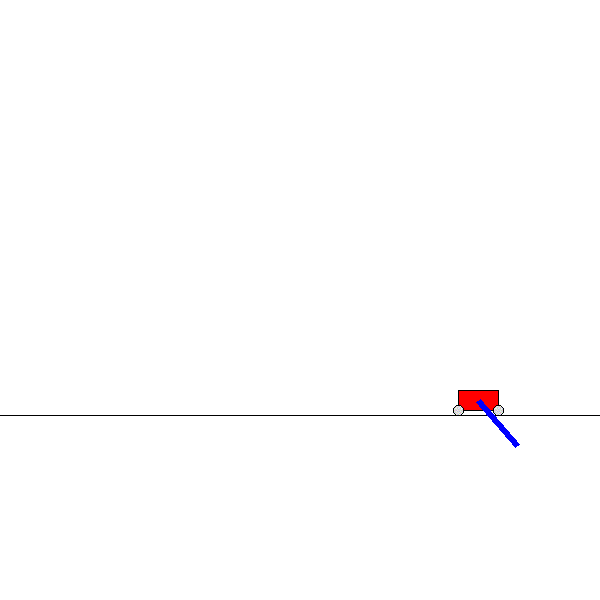

In [9]:
# @title Visualization

reset_fn = jax.jit(valid_env.reset)
step_fn = jax.jit(valid_env.step)
act_fn = jax.jit(policy.get_actions)
rollout_key = random.PRNGKey(seed=0)
images = []
s = reset_fn(rollout_key[None, :])
images.append(CartPoleSwingUp.render(s, 0))
done = False
total_reward = 0
step = 0
while not done:
    act = act_fn(s.obs, best_params[None, :])
    s, r, d = step_fn(s, act)
    step += 1
    total_reward += r[0]
    done = bool(d[0])
    if step % 5 == 0:
        images.append(CartPoleSwingUp.render(s, 0))

images[0].save(
    'cartpole.gif', save_all=True, append_images=images[1:],
    duration=40, loop=0)
print('steps={}, reward={}'.format(step, total_reward))
Image(open('cartpole.gif','rb').read())